In [ ]:
# %pip install wandb

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# import sys
# repo_path = '/content/drive/MyDrive/Github/color_constancy_domain_adaptation/'
# sys.path.append(repo_path)

Mounted at /content/drive


In [5]:
import sys
repo_path = '/Users/kirillprosvirin/GitLab/mlops-project'
sys.path.append(repo_path)

In [85]:
import os
import torch
import numpy as np
import torch
import torch.optim.lr_scheduler as lr
import matplotlib.pyplot as plt
import wandb

from tqdm import tqdm
from src.data.dataset import ColorConstancyDataset, DADataset
from src.data.dataset import Rescale, ToTensor
from src.models.nets import FullColorCerberusDA
from src.models.trainer import Trainer
from src.models.losses import DALoss

from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from functools import partial


In [86]:
SEED = 42
generator = torch.Generator()
generator.manual_seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path_to_save = repo_path + 'models'

BATCH_SIZE = 8
NUM_WORKERS = 2
NUM_EPOCH = 20

In [87]:
class model(FullColorCerberusDA):
    def __init__(self, *args, device='cpu', **kwargs):
        super().__init__(*args, **kwargs)
        self.device = device

In [97]:
dataset_train_s = ColorConstancyDataset(
    csv_file=repo_path + '/data/processed/SimpleCube++/train/gt.csv',
    root_dir=repo_path + '/data/processed/SimpleCube++/train/PNG',
    transform=transforms.Compose([
        Rescale((128, 192)),
        ToTensor()
    ])
)

dataset_train_t = ColorConstancyDataset(
    csv_file=repo_path + '/data/processed/TCC/train/gt.csv',
    root_dir=repo_path + '/data/processed/TCC/train/PNG',
    transform=transforms.Compose([
        Rescale((128, 192)),
        ToTensor()
    ])
)

dataset_test_s = ColorConstancyDataset(
    csv_file=repo_path + '/data/processed/SimpleCube++/test/gt.csv',
    root_dir=repo_path + '/data/processed/SimpleCube++/test/PNG',
    transform=transforms.Compose([
        Rescale((128, 192)),
        ToTensor()
    ])
)

dataset_test_t = ColorConstancyDataset(
    csv_file=repo_path + '/data/processed/TCC/test/gt.csv',
    root_dir=repo_path + '/data/processed/TCC/test/PNG',
    transform=transforms.Compose([
        Rescale((128, 192)),
        ToTensor()
    ])
)


In [98]:
len(dataset_train_t), len(dataset_test_t)

(2930, 1479)

In [99]:
TARGET_LABBELED_SIZE = 20
RATIO = [1, 1]

# Choose a random subset of target dataset of the length=TARGET_LABBELED_SIZE
if TARGET_LABBELED_SIZE:
    dataset_train_t_labeled, dataset_train_t_unlabeled = random_split(
        dataset_train_t,
        [TARGET_LABBELED_SIZE, len(dataset_train_t) - TARGET_LABBELED_SIZE],
        generator=generator,
    )

da_dataset_train = DADataset(
    src_dataset=dataset_train_s,
    trg_dataset=dataset_train_t_labeled,
    trg_dataset_unlabeled=dataset_train_t_unlabeled,
    ratio=RATIO
)

da_dataset_test = DADataset(
    src_dataset=dataset_test_s,
    trg_dataset=dataset_test_t,
    trg_dataset_unlabeled=None,
    ratio=[1, 0]
)

In [100]:
len(da_dataset_train), len(dataset_train_s), len(dataset_train_t_labeled), len(dataset_train_t_unlabeled)

(5316, 1772, 20, 2910)

In [101]:
dl_train = DataLoader(
    dataset=da_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=False)

dl_test = DataLoader(
    dataset=da_dataset_test,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=False)

In [102]:
DOMAIN_RATIO = 0.5

loss = DALoss(domain_ratio=DOMAIN_RATIO)
model_factory = partial(model)
optimizer_factory = partial(torch.optim.AdamW)
scheduler_factory = partial(lr.ExponentialLR)
model_params = dict(
    device=device
)
optimizer_params = dict(weight_decay=1e-4, lr=1e-4)
scheduler_params = dict(gamma=0.9)
other_params = dict(
    batch_size=BATCH_SIZE,
    domain_ratio=DOMAIN_RATIO,
    labeled_target_size=TARGET_LABBELED_SIZE,
    ratio=RATIO
)

learning_params = dict(num_epoch=NUM_EPOCH, use_amp=True)
forward_params = dict(alpha=0.01)
wandb_init_params = dict(
    name='TCC_exp4_delta20',
    project="DA",
    entity="prosvirinkir",
    notes=''
)


In [105]:
trainer = Trainer(
    dl_train, dl_test,
    loss,
    model_factory=model_factory,
    optimizer_factory=optimizer_factory,
    scheduler_factory=scheduler_factory,
    model_params=model_params,
    optimizer_params=optimizer_params,
    scheduler_params=scheduler_params,
    other_params=other_params,
    log=True,
    wandb_init_params=wandb_init_params,
    forward_params=forward_params,
)  # 81fde51a11b3e4cab0b3bfcf85cfe93b9b191ef6


In [106]:
trainer.train_model(learning_params)

/usr/local/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
Training:   0%|          | 0/665 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Validation: 100%|██████████| 116/116 [00:42<00:00,  2.71it/s]


Epoch: 1 of 20, 3.902 min


Validation: 100%|██████████| 116/116 [00:42<00:00,  2.73it/s]


Epoch: 2 of 20, 3.871 min


Validation: 100%|██████████| 116/116 [00:43<00:00,  2.68it/s]


Epoch: 3 of 20, 3.816 min


Validation: 100%|██████████| 116/116 [00:42<00:00,  2.72it/s]


Epoch: 4 of 20, 3.845 min


Validation: 100%|██████████| 116/116 [00:43<00:00,  2.64it/s]


Epoch: 5 of 20, 3.861 min


Validation: 100%|██████████| 116/116 [00:42<00:00,  2.70it/s]


Epoch: 6 of 20, 3.900 min


Validation: 100%|██████████| 116/116 [00:44<00:00,  2.63it/s]


Epoch: 7 of 20, 3.982 min


Validation: 100%|██████████| 116/116 [00:44<00:00,  2.62it/s]


Epoch: 8 of 20, 3.944 min


Validation: 100%|██████████| 116/116 [00:43<00:00,  2.66it/s]


Epoch: 9 of 20, 3.989 min


Validation: 100%|██████████| 116/116 [00:43<00:00,  2.67it/s]


Epoch: 10 of 20, 3.922 min


Training:   0%|          | 0/665 [00:00<?, ?it/s]

# Calculate metrics

In [ ]:
dl_test_s = DataLoader(
    dataset=dataset_test_s,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=False)

dl_test_t = DataLoader(
    dataset=dataset_test_t,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=False)


In [ ]:
from tabulate import tabulate

In [ ]:
def angular_error(net, dl, device):
    errors = []
    net.eval()
    with torch.no_grad():
        for data_t in dl:
            images, gt = data_t['image'].to(device), data_t['light_source'].to(device)
            outputs, _ = net(images, 0)
            outputs = outputs.cpu().numpy()
            gt = gt.cpu().numpy()

            outputs_norm = outputs / np.linalg.norm(outputs, axis=1, keepdims=True)
            gt_norm = gt / np.linalg.norm(gt, axis=1, keepdims=True)

            batch_err = np.degrees(np.arccos(np.clip(np.sum(outputs_norm * gt_norm, axis=1), -1.0, 1.0)))
            errors.append(batch_err)

    return np.concatenate(errors)


def random_sample(values):
    idxes = np.random.choice(len(values), len(values), replace=True)
    return values[idxes]


def get_ci(values, conf_level=0.95):
    return np.percentile(values, (1 - conf_level) / 2), np.percentile(values, conf_level + (1 - conf_level) / 2)


def calc_angular_error_bs(dl, net, device):
    errors = angular_error(net, dl, device)
    avg = []
    p25 = []
    p50 = []
    p75 = []
    avg_10worst = []
    for _ in tqdm(range(10000)):
        sample = random_sample(errors)
        avg.append(np.mean(sample))
        p25.append(np.percentile(sample, q=25))
        p50.append(np.percentile(sample, q=50))
        p75.append(np.percentile(sample, q=75))
        avg_10worst.append(np.mean(np.sort(sample)[-10:]))

    return dict(avg=avg, p25=p25, p50=p50, p75=p75, avg_10worst=avg_10worst)


def calc_test_errors(dl_s, dl_t, trainer, device):

    s_out = calc_angular_error_bs(dl_test_s, trainer.model, device)
    t_out = calc_angular_error_bs(dl_test_t, trainer.model, device)
    res = dict(data=['src', 'target'], avg=[], p25=[], p50=[], p75=[], avg_10worst=[])
    for (s_key, s_val), (t_key, t_val) in zip(s_out.items(), t_out.items()):
        s_ci = get_ci(s_val)
        res[s_key].append(f'{round(s_ci[0], 2)}-{round(s_ci[1], 2)}')
        t_ci = get_ci(t_val)
        res[t_key].append(f'{round(t_ci[0], 2)}-{round(t_ci[1], 2)}')

    # wandb.config.update({'angular_error_test_s': f'{round(s_ci[0], 2)}-{round(s_ci[1], 2)}'})
    # wandb.config.update({'angular_error_test_t': f'{round(t_ci[0], 2)}-{round(t_ci[1], 2)}'})
    # print(tabulate(res, format='simple'))
    return res
    # print('angular_error_test_s: ', f'{round(s_ci[0], 2)}-{round(s_ci[1], 2)}')
    # print('angular_error_test_t: ', f'{round(t_ci[0], 2)}-{round(t_ci[1], 2)}')


In [ ]:
res = calc_test_errors(dl_test_s, dl_test_t, trainer, 'cuda:0')


In [ ]:
print(tabulate(res, res.keys(), tablefmt='github'))


| data   | avg       | p25       | p50      | p75       | avg_10worst   |
|--------|-----------|-----------|----------|-----------|---------------|
| src    | 1.92-2.04 | 0.45-0.49 | 1.03-1.1 | 2.23-2.58 | 9.35-10.41    |
| target | 3.06-3.65 | 1.05-1.18 | 1.63-1.7 | 2.83-3.6  | 10.95-13.33   |


| data   | avg       | p25       | p50       | p75       | avg_10worst   |
|--------|-----------|-----------|-----------|-----------|---------------|
| src    | 2.61-2.75 | 0.91-0.97 | 1.7-1.84  | 3.27-3.45 | 10.08-10.72   |
| target | 2.74-3.06 | 1.34-1.35 | 1.76-1.84 | 2.94-3.43 | 7.4-8.4       |

In [ ]:
s_out = angular_error(trainer.model, dl_test_s, device)
t_out = angular_error(trainer.model, dl_test_t, device)


In [ ]:
np.percentile(t_out, q=25)


1.5431860434614948

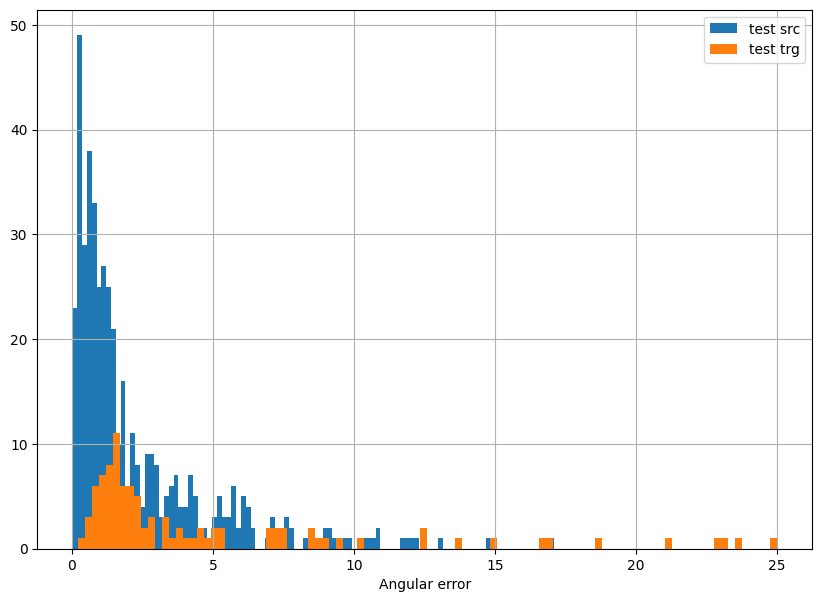

In [ ]:
plt.figure(figsize=(10, 7))
plt.hist(s_out, bins=100, label='test src')
plt.hist(t_out, bins=100, label='test trg')
plt.grid()
plt.xlabel('Angular error')
plt.legend()
plt.savefig('error_distr_on_test.png')
# Tail of this distribution is long enough so we need consider the fact that on those images the error will be a lot higher than mean value.


# Load weights


In [40]:
run = wandb.init()  # 81fde51a11b3e4cab0b3bfcf85cfe93b9b191ef6
exp_name = 'prosvirinkir/DA/TAU_exp4_delta20:v1'
artifact = run.use_artifact(exp_name, type='model')
model = FullColorCerberusDA()
model.load_state_dict(torch.load(artifact.file(), map_location=device))

<All keys matched successfully>

In [63]:
min_t = [x['image'].min() for x in dataset_test_t]
mean_t = [x['image'].mean() for x in dataset_test_t]
max_t = [x['image'].max() for x in dataset_test_t]

In [75]:
np.mean(min_t), np.mean(mean_t), np.mean(max_t)

(0.0018742791234140795, 0.07800053067655269, 0.5766724336793532)

In [62]:
min_s = [x['image'].min() for x in dataset_test_s]
mean_s = [x['image'].mean() for x in dataset_test_s]
max_s = [x['image'].max() for x in dataset_test_s]

In [74]:
np.mean(min_s), np.mean(mean_s), np.mean(max_s)

(0.0, 0.03826881700930625, 0.12983160120108647)

In [ ]:
batch = next(iter(dl_train))['image']

In [38]:
len(batch), batch[:4].mean(), batch[4:].mean()

(8, tensor(0.0634, dtype=torch.float64), tensor(0.0896, dtype=torch.float64))

In [39]:
with torch.no_grad():
    model.eval()
    output = model(next(iter(dl_train))['image'], 0)
print(output)

(tensor([[0.3947, 0.8102, 0.3748],
        [0.3818, 0.7892, 0.3736],
        [0.2286, 0.4602, 0.2510],
        [0.3820, 0.7788, 0.3652],
        [0.3631, 0.7280, 0.3474],
        [0.3620, 0.7328, 0.3476],
        [0.3686, 0.7368, 0.3499],
        [0.2241, 0.4500, 0.2478]], dtype=torch.float64), tensor([[1.7876],
        [1.7917],
        [0.6112],
        [1.8117],
        [1.3122],
        [1.3599],
        [1.3784],
        [0.4935]], dtype=torch.float64))


In [ ]:
def mean_angular_error(net, dl, device):
    errors = []
    net.eval()
    with torch.no_grad():
        for data_t in dl:
            images, gt = data_t['image'].to(device), data_t['light_source'].to(device)
            outputs, _ = net(images, 0)
            outputs = outputs.cpu().numpy()
            gt = gt.cpu().numpy()

            outputs_norm = outputs / np.linalg.norm(outputs, axis=1, keepdims=True)
            gt_norm = gt / np.linalg.norm(gt, axis=1, keepdims=True)
            angles = np.degrees(np.arccos(np.clip(np.sum(outputs_norm * gt_norm, axis=1), -1.0, 1.0)))
            batch_err = np.sum(angles)
            errors.append(batch_err)

    return np.sum(errors) / len(dl.dataset)


In [ ]:
mean_angular_error(trainer.model, dl_test_t, device)


4.903191586496921

In [ ]:
mean_angular_error(trainer.model, dl_test_s, device)


2.3126443621370054

In [ ]:
# This script is to calculate statistics based on
# results.csv

import numpy as np
import pandas as pd


def csv_to_df(csv_file):
    df = pd.read_csv(csv_file)
    return df


def calc_mean(df):
    stats = []
    for column in df:
        if column != 'image':
            data = df[column]
            stat = np.mean(data)
            stats.append(stat)
    return stats


def calc_median(df):
    stats = []
    for column in df:
        if column != 'image':
            data = df[column]
            stat = np.median(data)
            stats.append(stat)
    return stats


def array_slice(array, percent):
    array = sorted(array, reverse=True)
    length = len(array)
    slice_size = length * percent // 100
    return array[:slice_size]


def calc_mean_10p_worst(df):
    stats = []
    for column in df:
        if column != 'image':
            data = array_slice(df[column], 10)
            stat = np.mean(data)
            stats.append(stat)
    return stats


def calc_mean_1p_worst(df):
    stats = []
    for column in df:
        if column != 'image':
            data = array_slice(df[column], 1)
            stat = np.mean(data)
            stats.append(stat)
    return stats


def calc_stats(results_df):
    alg_names = ['KEKKEKEKEKEKE']
    stat_names = ['mean', 'median', 'mean_10p_worst', 'mean_1p_worst']

    mean = calc_mean(results_df)
    median = calc_median(results_df)
    mean_10p_worst = calc_mean_10p_worst(results_df)
    mean_1p_worst = calc_mean_1p_worst(results_df)

    stats = np.array([mean, median, mean_10p_worst, mean_1p_worst]).T
    stats_df = pd.DataFrame(stats, index=alg_names, columns=stat_names)
    return stats_df


def calc_angle(v1, v2):
    v1 = np.array(v1) / np.linalg.norm(v1, ord=2)
    v2 = np.array(v2) / np.linalg.norm(v2, ord=2)
    return np.arccos((v1 * v2).sum().clip(-1, 1)) / np.pi * 180


def calc_angular_errors(pred, gt):
    assert pred.shape == gt.shape

    alg_scores = []
    for i in range(len(pred)):
        alg_scores.append(calc_angle(pred[i], gt[i]))
    alg_scores = np.array([alg_scores]).T
    alg_scores_df = pd.DataFrame(alg_scores, columns=['gw'])
    stats_df = calc_stats(alg_scores_df)

    return stats_df


In [ ]:
net = trainer.model
net.eval()
results = []
gts = []
with torch.no_grad():
    for data_t in dl_test_t:
        images, gt = data_t['image'].to(device), data_t['light_source'].to(device)
        outputs, _ = net(images, 0)
        outputs = outputs.cpu().numpy()
        results.append(outputs)
        gts.append(gt)


In [ ]:
preds = np.concatenate(results)


In [ ]:
gts = np.concatenate(gts)


In [ ]:
calc_angular_errors(preds, gts)


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean   median  mean_10p_worst  mean_1p_worst
KEKKEKEKEKEKE  3.780833  2.32298       11.779346            NaN